In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import difflib
from termcolor import colored
import editdistance as ed
import json

%matplotlib inline

Experiment Summary:

Experiment **1**: Document: Vādakautūhala________________Train Data Size : 288 lines -- 3 cross validation folds \
Experiment **2**: Document: Dvādaśamahāvākyavicāraḥ___Train Data Size : 196 lines -- 3 cross validation folds \
Experiment **3**: Document: Mahāvākyārtha_______________Train Data Size : 58 lines ---- 3 cross validation folds 

In [117]:
# Select the experiment results to analyze
experiment_number = 3

In [118]:
fold_1_path = f'outputs\experiment_{experiment_number}\\test_fold_1/'
fold_2_path = f'outputs\experiment_{experiment_number}\\test_fold_2/'
fold_3_path = f'outputs\experiment_{experiment_number}\\test_fold_3/'

# we combine the results of all cross validataion folds together for easy visualization 
# not ideal, because each cross validation fold has different model selected based of the validation error
# we can easily modify these to look at singles folds individually - which gives similar results

csv_file_path_1 = fold_1_path +'analysis.csv'
csv_file_path_2 = fold_2_path +'analysis.csv'
csv_file_path_3 = fold_3_path +'analysis.csv'
df_1 = pd.read_csv(csv_file_path_1, delimiter=';', encoding='utf-8')
df_2 = pd.read_csv(csv_file_path_2, delimiter=';', encoding='utf-8')
df_3 = pd.read_csv(csv_file_path_3, delimiter=';', encoding='utf-8')

# Load the CSV file
df = pd.concat([df_1, df_2, df_3], axis=0, ignore_index=True)


# Similarly we comibine together the json files which record types of errors made, and their frequencies for all the 3 folds.

error_counts_train_paths = [
    fold_1_path + 'error_counts_train.json',
    fold_2_path + 'error_counts_train.json',
    fold_3_path + 'error_counts_train.json'
]
error_counts_test_paths = [
    fold_1_path + 'error_counts_test.json',
    fold_2_path + 'error_counts_test.json',
    fold_3_path + 'error_counts_test.json'
]

# Initialize an empty dictionary to store the combined data
data_train = {}
# Load and combine the JSON files
for path in error_counts_train_paths:
    with open(path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        # Merge the loaded data into the combined_data dictionary
        data_train.update(data)

data_test = {}
# Load and combine the JSON files
for path in error_counts_test_paths:
    with open(path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        # Merge the loaded data into the combined_data dictionary
        data_test.update(data)

# Helper Fuctions

In [119]:

from IPython.display import display, HTML

def format_json(data):
    # Recursive function to format JSON data
    def format_item(item):
        if isinstance(item, dict):
            formatted = "<ul>"
            for key, value in item.items():
                formatted += f"<li><strong>{key}:</strong> {format_item(value)}</li>"
                formatted += f"<br>"
            formatted += "</ul>"
            return formatted
        elif isinstance(item, list):
            formatted = "<ul>"
            for sub_item in item:
                formatted += f"<li>{format_item(sub_item)}</li>"
                formatted += f"<br>"
            formatted += "</ul>"
            return formatted
        else:
            return f"<span>{item}</span>"
    
    return format_item(data)

def display_side_by_side(json_data1, json_data2, title1="JSON File 1", title2="JSON File 2"):
    formatted_json1 = format_json(json_data1)
    formatted_json2 = format_json(json_data2)
    
    # Create HTML for side-by-side display
    html = f"""
    <div style="display: flex; justify-content: space-between;">
        <div style="width: 45%; padding: 10px; border: 1px solid #ddd; box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.1);">
            <h3>{title1}</h3>
            {formatted_json1}
        </div>
        <div style="width: 45%; padding: 10px; border: 1px solid #ddd; box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.1);">
            <h3>{title2}</h3>
            {formatted_json2}
        </div>
    </div>
    """
    
    display(HTML(html))

def highlight_changes(line1, line2, post_corrected=False):
    # Generate a diff between the two lines
    diff = list(difflib.ndiff(line1, line2))

    # Create colored output based on diff
    highlighted_line1 = []
    highlighted_line2 = []

    i = 0
    while i < len(diff):
        if diff[i].startswith('- ') and i+1 < len(diff) and diff[i+1].startswith('+ '):
            # Replace operation
            highlighted_line1.append(colored(diff[i][2:], 'yellow', attrs=['bold']))
            highlighted_line2.append(colored(diff[i+1][2:], 'yellow', attrs=['bold']))
            i += 2
        elif diff[i].startswith('- '):
            # Delete operation
            highlighted_line1.append(colored(diff[i][2:], 'blue', attrs=['bold']))
            highlighted_line2.append(colored(' ', 'blue', attrs=['bold']))
            i += 1
        elif diff[i].startswith('+ '):
            # Insert operation
            highlighted_line1.append(colored(' ', 'red', attrs=['bold']))
            highlighted_line2.append(colored(diff[i][2:], 'red', attrs=['bold']))
            i += 1
        elif diff[i].startswith('  '):
            # Unchanged characters
            highlighted_line1.append(diff[i][2:])
            highlighted_line2.append(diff[i][2:])
            i += 1
        else:
            # Skip '?' lines
            i += 1

    final_line1 = ''.join(highlighted_line1)
    final_line2 = ''.join(highlighted_line2)

    # Ensure equal length by padding with spaces
    max_length = max(len(final_line1), len(final_line2))
    final_line1 = final_line1.ljust(max_length)
    final_line2 = final_line2.ljust(max_length)

    if post_corrected:
        print("Ground Truth  : " + final_line2)
        print("Post Corrected: " + final_line1)
    else:
        print("OCR Output    : " + final_line1)
        print("Ground Truth  : " + final_line2)

# Example usage:
highlight_changes("abcdefg", "abxcefh")

def analyse_line(df,id):
    print("CER Before Post Correction:"+str(df['pre_cer'].iloc[id]*100)+" %")
    print("CER After Post Correction :"+str(df['post_cer'].iloc[id]*100)+" %")
    print("\n")

    
    absolute_image_path = df['path'].iloc[id]

    #BELOW CODE AJUSTS THE LINE IMAGE PATHS(FOR WINDOWS)
    # Split the string by '/'
    parts = absolute_image_path.split('/')
    # Remove the first two elements
    parts = parts[4:]  # Skip the first two elements
    # Join the remaining elements using '//'
    relative_path_windows = '//'.join(parts)

    # Load and display the image using matplotlib
    img = mpimg.imread(relative_path_windows)

    # Print legend
    print(colored("Blue     ", "blue") + ": Extra")
    print(colored("Red      ", "red") + ": Missing")
    print(colored("Yellow   ", "yellow") + ": Replaced")
    print("No color : Unchanged")
    print('\n')


    plt.figure(figsize=(30, 30))
    plt.axis('off')
    plt.imshow(img, cmap='gray')


    highlight_changes(df['input_text'].iloc[id], df['target_text'].iloc[id])
    print('')
    highlight_changes(df['predicted_text'].iloc[id], df['target_text'].iloc[id],post_corrected=True)

    print('\nOriginal Line Image:')

OCR Output    : ab cdefg
Ground Truth  : abxc efh


# REPORT

## How many lines does post-correction benefit, and by how much?

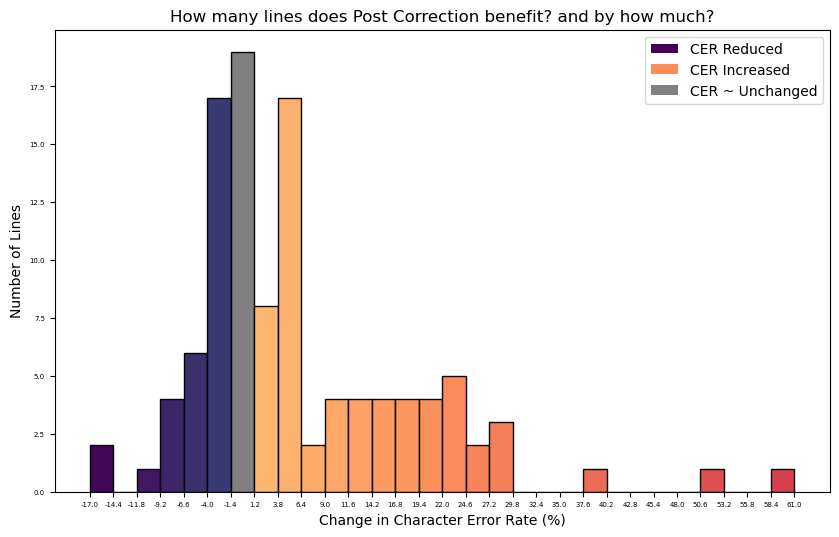

In [120]:
# Plot histogram and get bin edges and counts
plt.figure(figsize=(10, 6))
counts, bin_edges, patches = plt.hist(df['difference']*100, bins=30, edgecolor='black')

# Normalize bin edges for color mapping
norm = plt.Normalize(bin_edges.min(), bin_edges.max())

# Create custom colormaps that are more color-blind friendly
colors_neg = ['#440154', '#31688e', '#35b779', '#fde725']  # Viridis-like
colors_pos = ['#fee08b', '#fc8d59', '#d53e4f']  # YlOrRd-like

cmap_neg = mcolors.LinearSegmentedColormap.from_list("custom_neg", colors_neg)
cmap_pos = mcolors.LinearSegmentedColormap.from_list("custom_pos", colors_pos)

# Apply colors to bars
for i, patch in enumerate(patches):
    # Determine bin edges
    left_edge = bin_edges[i]
    right_edge = bin_edges[i + 1]
    
    # Check if bin includes zero
    if left_edge <= 0 <= right_edge:
        # Set the color of the bin that includes zero to gray
        color = 'gray'
    elif right_edge < 0:
        # Color for bins with negative values
        bin_center = (left_edge + right_edge) / 2
        color = cmap_neg(norm(bin_center))
    else:
        # Color for bins with positive values
        bin_center = (left_edge + right_edge) / 2
        color = cmap_pos(norm(bin_center))
    
    patch.set_facecolor(color)


plt.xticks(ticks=bin_edges, fontsize=5)
plt.yticks(fontsize=5)  # Decrease the font size of x-axis ticks
# Format x-axis tick labels to one decimal place
formatter = FuncFormatter(lambda x, _: f'{x:.1f}')
plt.gca().xaxis.set_major_formatter(formatter)

plt.title('How many lines does Post Correction benefit? and by how much?')
plt.xlabel('Change in Character Error Rate (%)')
plt.ylabel('Number of Lines')

# Add legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, fc='#440154', label='CER Reduced'),
    plt.Rectangle((0, 0), 1, 1, fc=cmap_pos(0.5), label='CER Increased'),
    plt.Rectangle((0, 0), 1, 1, fc='gray', label='CER ~ Unchanged')
]
plt.legend(handles=legend_elements, loc='upper right')

# Show the plot
plt.show()

## Removing Abnormally Hallucinated Lines (without needing ground truth labels)

We observe that: **If post corrected Line A's CER compared with the ground truth is bad, then the post corrected Line A's CER when compared with the OCR output would also be bad.** We can use this observation to catch abnormal lines without the need to have ground truth labels - using heuristic thresholding.


In machine learning it is common to split the data we have into training data, validation data and test data. The validation data helps us fine tune the hyperparameters, and the test data helps us gauge how our model will perform when deployed.\
Both, Validataion Data and Test Data are proxys for what we would observe after deployment. But unlike the Validation and Test splits, the data we observe after deployment does not have ground truth labels.\
Similarly, we have ground truth labels for our validation and test datasets. We observe that sometimes the model hallucinates really bad for some lines which brings down the CER for the entire page/manuscript. We would like to catch these lines, even in the absense of ground truth data - which would be the case when the model is deployed.

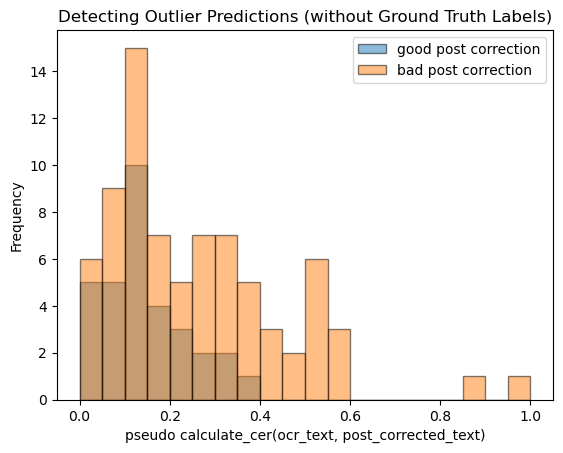

Abnormal Line at index: 14
Abnormal Line at index: 16
Abnormal Line at index: 17
Abnormal Line at index: 18
Abnormal Line at index: 20
Abnormal Line at index: 21
Abnormal Line at index: 22
Abnormal Line at index: 23
Abnormal Line at index: 24
Abnormal Line at index: 25
Abnormal Line at index: 26
Abnormal Line at index: 27
Abnormal Line at index: 28
Abnormal Line at index: 29
Abnormal Line at index: 30
Abnormal Line at index: 31
Abnormal Line at index: 32
Abnormal Line at index: 33
Abnormal Line at index: 34
Abnormal Line at index: 35
Abnormal Line at index: 36
Abnormal Line at index: 58
Abnormal Line at index: 62
Abnormal Line at index: 64
Abnormal Line at index: 65
Abnormal Line at index: 66
Abnormal Line at index: 67
Abnormal Line at index: 68
Abnormal Line at index: 69
Abnormal Line at index: 70
Abnormal Line at index: 71
Abnormal Line at index: 72
Abnormal Line at index: 100
Abnormal Line at index: 101
Abnormal Line at index: 105
Abnormal Line at index: 106
Abnormal Line at index: 

In [121]:

def calculate_cer(predicted_text, transcript):
    cer = ed.eval(predicted_text, transcript) / max(len(predicted_text), len(transcript))
    return cer

good_pseudo = []
bad_pseudo = []
bad_pseudo_indices = []
good_pseudo_indices = []

ocr_errors = []
post_correction_errors = []

for index, row in df.iterrows():
    input_text = row['input_text']
    predicted_text = row['predicted_text']
    target_text = row['target_text']


    ocr_error = calculate_cer(input_text, target_text) #we need ground truth for this
    post_correction_error = calculate_cer(predicted_text, target_text) # we need ground truth for this too
    pseudo_error = calculate_cer(input_text, predicted_text) # this is ALWAYS availabe!

    # can we use pseudo error to guess when the (post_correction_error - ocr_error) would be positive(bad)
    if post_correction_error-ocr_error <0: #GOOD
        good_pseudo.append(pseudo_error)
        good_pseudo_indices.append(index)
    else: #BAD
        bad_pseudo.append(pseudo_error)
        bad_pseudo_indices.append(index)

    post_correction_errors.append(post_correction_error)
    ocr_errors.append(ocr_error)


# Create the histogram plot
# Determine the overall range of the data
min_val = min(np.min(good_pseudo), np.min(bad_pseudo))
max_val = max(np.max(good_pseudo), np.max(bad_pseudo))
# Create an array of bin edges
bins = np.linspace(min_val, max_val, 21)  # 21 edges to create 20 bins

# Plot the histograms
plt.hist(good_pseudo, bins=bins, alpha=0.5, label='good post correction', edgecolor='black')
plt.hist(bad_pseudo, bins=bins, alpha=0.5, label='bad post correction', edgecolor='black')

# Add labels and title
plt.xlabel('pseudo calculate_cer(ocr_text, post_corrected_text)')
plt.ylabel('Frequency')
plt.title('Detecting Outlier Predictions (without Ground Truth Labels)')
plt.legend(loc='upper right')

# Show the plot
plt.show()

abnormal_lines_indices = []
for val,i in zip(bad_pseudo,bad_pseudo_indices):
    if val>0.20:  # 0.20 is the threshold we use
        print(f'Abnormal Line at index: {i}')
        abnormal_lines_indices.append(i)

In [122]:
# for abnormal lines, we do not apply post correction - we keep the OCR output as it is.
def keep_abnormal_lines_unchanged(post_correction_errors,ocr_errors,indices_to_remove):
    return_this = []
    for index, (item1, item2) in enumerate(zip(post_correction_errors, ocr_errors)):
        if index not in indices_to_remove:
            return_this.append(item1)
        else:
            return_this.append(item2)
    return return_this


## Results

In [123]:
print(f'The CER of the OCRed Text is {np.mean(ocr_errors)}.\nThe CER of the Post-Corrected Text is {np.mean(post_correction_errors)}.\nAfter Removing Abnormal Lines the CER becomes {np.mean(keep_abnormal_lines_unchanged(post_correction_errors,ocr_errors,abnormal_lines_indices))}')

The CER of the OCRed Text is 0.29703155881201965.
The CER of the Post-Corrected Text is 0.35823385490549214.
After Removing Abnormal Lines the CER becomes 0.29266086581169126


## Line By Line Analysis

CER Before Post Correction:39.0 %
CER After Post Correction :24.0 %


Blue     : Extra
Red      : Missing
Yellow   : Replaced
No color : Unchanged


OCR Output    : śrī  chaluṣ āthayanamaḥ..J mahāvākyāry as   yate..kadhama
Ground Truth  : śrīkṛ     ṣṇā   yanamaḥ..oṃmahāvākyārthasmaryate.. athama

Ground Truth  : śrīkṛṣṇā yanamaḥ..oṃmahāvākyārthasmaryate..at    hama 
Post Corrected: śrīkṛṣṇāryanamaḥ..  mahāvākyārthas   yate..  kiṃdhamaṃ

Original Line Image:


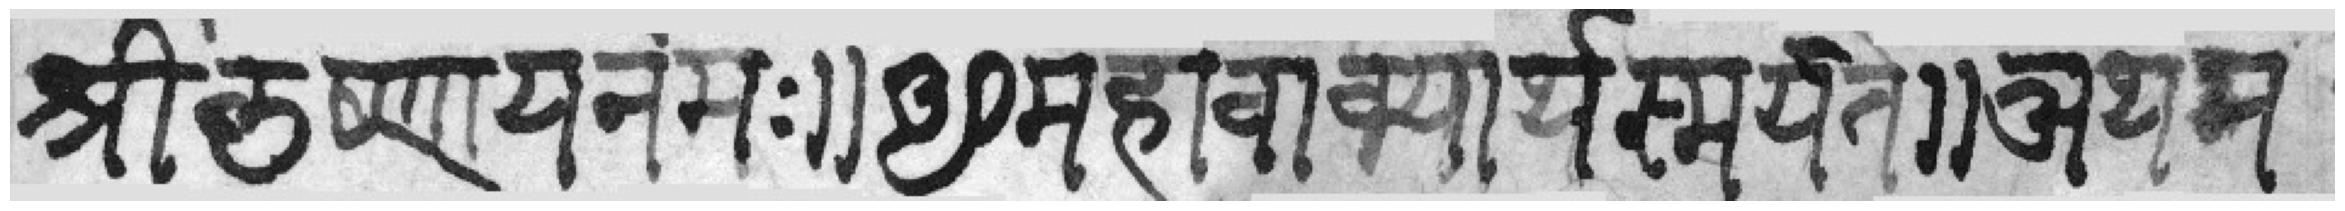

In [125]:
analyse_line(df,0) # enter line index

## Sanity Check - what has Sanskrit-Byt5 learnt?

In [116]:

display_side_by_side(data_train, data_test, title1="Edits made to OCR OUTPUT to get to GROUND TRUTH (on Train Data)", title2="Edits made to OCR OUTPUT to get to POST CORRECTED TEXT (on Test Data)")
